In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os

%matplotlib notebook
#%matplotlib inline

from ipywidgets import interact #, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def rename_string_to_label(string):
    return(string.replace('b-pulseAlongX_0.22','UV').replace('z-from_S1_without_pulse','FC_1').replace('m-only_IR_longer_with_nac_2_1','IR_long').replace('_0000',''))

In [3]:
fol = '/home/alessio/k-nokick/'

subfolders = sorted([dir for dir in os.listdir(fol) if os.path.isdir(os.path.join(fol,dir)) and dir not in ['HTML','csv']])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> a-restart_b-pulseAlongX_0.22_0000
1 -> b-pulseAlongX_0.22_0000
2 -> b-pulseAlongX_0.22_goodG_0000
3 -> b-pulseAlongX_0.22_short_0_0000
4 -> b-pulseAlongX_0.22_short_0_goodG_0000
5 -> b-pulseAlongX_0.22_short_pi_0000
6 -> b-pulseAlongX_0.22_short_pi_goodG_0000
7 -> m-only_IR_longer_with_nac_2_1_0000
8 -> m-only_IR_longer_with_nac_2_1_counterClock_0000
9 -> m-only_IR_longer_with_nac_2_1_inverted_phase_0000
10 -> m-only_IR_longer_with_nac_2_1_phase_pi_0000
11 -> m-only_IR_short_with_nac_2_1_0000
12 -> m-only_IR_short_with_nac_2_1_inverted_phase_0000
13 -> m-only_IR_short_with_nac_2_1_phase_pi_0000
14 -> z-from_S1_without_pulse_0000
15 -> z-from_S2_without_pulse_0000



In [4]:
listZ = [3,4,5,6] # only IR
listZ = [0,2,4] # only UV
listZ = [1,14] # only UV

runs = [subfolders[x] for x in listZ]

def make_dictio_of_data(name,fol):
    '''
    from name to dictio of data
    '''
    csv_fol = os.path.join(fol,'csv')
    file1 = 'Report_' + name + '_populations.csv'
    file2 = 'Report_' + name + '_regions.csv'
    df1 = pd.read_csv(os.path.join(csv_fol,file1))
    df2 = pd.read_csv(os.path.join(csv_fol,file2))
    dic = {'name': name, 'pop' : df1, 'reg' : df2}
    return(dic)

all_data = [make_dictio_of_data(run,fol) for run in runs]
quantity = len(all_data)

In [5]:
def make_single_state_graph(all_of_them, state):
    fig , ax0 = plt.subplots(1, 1,figsize=(10,5))
    ax0.set_title(r'population in S{}'.format(state-1))
    for run in all_of_them:
        lab = rename_string_to_label(run['name'])
        data_sheet_run = run['pop']
        state_population = data_sheet_run[str(state)]
        state_fs = data_sheet_run['fs']
        ax0.plot(state_fs,state_population,label=lab)
    ax0.legend()    



# for i in [1,2,3,4,5,6,7,8]:
#     make_single_state_graph(all_data,i)

In [6]:
def calcola2(df_dictio,end_of_pulse_step,end_of_dyns_step,verbose=None):
    verbose = verbose or False
    df = df_dictio['pop']
    label = df_dictio['name']
    time = df.iloc[end_of_pulse_step]['fs']
    time2 = df.iloc[end_of_dyns_step]['fs']
    
    a = df.iloc[[end_of_pulse_step,end_of_dyns_step]]['1']
    da = a.iloc[1] - a.iloc[0]
    b = df.iloc[end_of_pulse_step]['2']
    c = da/b
    total_initial = df.iloc[0]['Total']
    total_final = df.iloc[end_of_dyns_step]['Total']
    total = total_final - total_initial
    
    string = '{}\n\n  time of end pulse -> {:8.3f} fs\n  time of end dyn -> {:8.3f} fs\n  gain in population S0 at the end_step: {:8.5f}\n  S1 population after pulse: {:8.5f}\n  Ratio: {:8.5f}\n  Total = {:6.3f} Hartree\n\n'
        
    if verbose:
        print(string.format(label,time,time2,da,b,c,total))
        
    return da,c

In [7]:
# THE NORM LOSS IS UPDATED BY THE REPORT CREATOR !!

def do_stuffs_to_thing(dictiona,frames_I_want):
    time = frames_I_want//25
    data_frame_to_consider = dictiona['pop']
    regionsData = dictiona['reg']

    # I get the AU of integration by reading the second line of the dataframe
    DELTAS = qp.fromFsToAu(data_frame_to_consider['fs'].iloc[1])
    data_frame_to_consider['Norm Loss Integrated'] = data_frame_to_consider['Norm Loss'].fillna(0) * DELTAS
    a = data_frame_to_consider['Norm Loss Integrated']
    Norm_loss_divided_by_25 = np.sum(a[:frames_I_want].values.reshape((time), -1),axis=1)

    regionsdata_ingraph = regionsData[:time].copy()

    regionsdata_ingraph['Norm Loss Integrated 2'] = Norm_loss_divided_by_25
    regionsdata_ingraph['Total Products'] = regionsdata_ingraph['products'] + regionsdata_ingraph['Norm Loss Integrated 2']
    return(regionsdata_ingraph)

time = 2200

UV = do_stuffs_to_thing(all_data[0],time)
FC = do_stuffs_to_thing(all_data[1],time//2)


In [8]:
UV

,Unnamed: 0,FC,reactants,products,fs,Norm Loss Integrated 2,Total Products
0,0,1.000000,1.133342e-17,1.405162e-35,0.000000,-1.741057e-57,1.405162e-35
1,1,0.999989,2.600369e-11,4.255002e-27,1.250000,-7.925698e-47,4.255002e-27
2,2,0.999957,4.555173e-10,2.767833e-21,2.500000,-4.639980e-41,2.767833e-21
3,3,0.999903,1.306599e-09,1.129789e-16,3.750000,-3.289615e-35,1.129789e-16
4,4,0.999828,1.484050e-09,4.111431e-14,4.999999,-2.779129e-30,4.111431e-14
5,5,0.999731,1.166995e-09,4.849049e-13,6.249999,-2.838756e-26,4.849049e-13
6,6,0.999605,1.589269e-09,4.244514e-12,7.499999,-8.701506e-23,4.244514e-12
7,7,0.988180,2.316580e-09,3.831706e-11,8.749999,-5.005210e-20,3.831706e-11
8,8,0.830781,2.254707e-09,1.179439e-10,9.999999,-7.767952e-18,1.179439e-10
9,9,0.651904,4.186623e-09,3.232633e-10,11.249999,-9.602027e-16,3.232623e-10


<IPython.core.display.Javascript object>


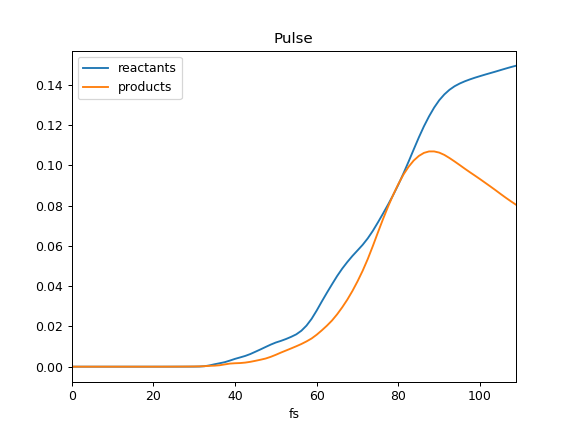

<IPython.core.display.Javascript object>


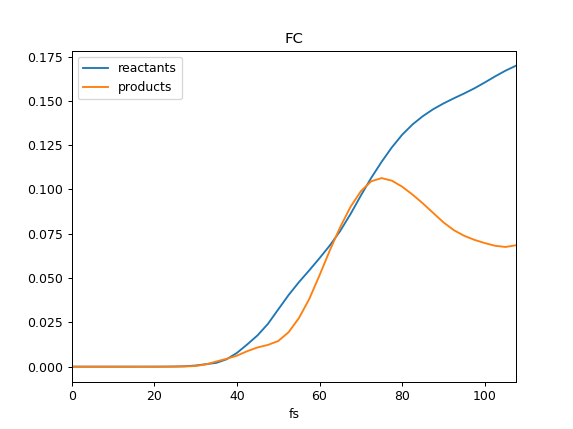

In [9]:
UV.plot('fs',['reactants','products'],title = 'Pulse')
FC.plot('fs',['reactants','products'],title = 'FC')

In [15]:
normalize = True

if normalize:
    UV_norm = UV['products'] + UV['reactants']
    FC_norm = FC['products'] + FC['reactants']
    
else:
    FC_norm,UV_norm = 1.0,1.0
    
UV_ratio = (UV['products']/UV['reactants'])*UV_norm
UV_fs = UV['fs']
FC_ratio = np.nan_to_num(FC['products']/FC['reactants'])*FC_norm
FC_fs = FC['fs']

In [10]:
fig , [ax0,ax1] = plt.subplots(2, 1,sharex = True,figsize=(20,20))
fig.subplots_adjust(hspace=0)
plt.rcParams.update({'font.size': 22})

ax0.plot(FC_fs,np.cumsum(FC_ratio),label='int FC')
ax0.plot(UV_fs,np.cumsum(UV_ratio),label='int UV')
ax0.set_title('Products/Reactants ratio integral')
ax0.set_ylabel('sum of ratios')
ax0.legend()

ax1.plot(FC_fs,FC_ratio,label='FC')
ax1.plot(UV_fs,UV_ratio,label='UV')
ax1.set_title('Products/Reactants ratio')
ax1.set_ylabel('ratio')
ax1.legend();

<IPython.core.display.Javascript object>

NameError: name 'FC_fs' is not defined

In [103]:
all_data[0]['pop']

,Unnamed: 0,count,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,...,0,1,2,3,4,5,6,7,8,Norm Loss Integrated
0,0,0,0,0.000000,2.331468e-15,0.091654,0.091279,0.182933,0.000000e+00,2.612992e-30,...,0.0000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.206089e-66
1,1,1,100,0.050050,1.741658e-08,0.091655,0.091278,0.182933,7.547859e-09,4.662243e-30,...,0.0501,1.000000,3.369610e-12,4.103880e-09,4.466580e-10,5.830640e-10,2.391940e-09,1.781660e-09,6.039230e-09,-2.206408e-66
2,2,2,200,0.100100,6.966588e-08,0.091658,0.091275,0.182933,3.019065e-08,6.372605e-30,...,0.1001,1.000000,1.206450e-11,1.549630e-08,1.656760e-09,2.149190e-09,8.722910e-09,6.215390e-09,2.059940e-08,-2.208025e-66
3,3,3,300,0.150150,1.567467e-07,0.091664,0.091269,0.182933,6.792649e-08,4.613039e-30,...,0.1502,1.000000,2.254310e-11,3.164530e-08,3.291250e-09,4.211130e-09,1.680470e-08,1.114380e-08,3.547180e-08,-2.211105e-66
4,4,4,400,0.200200,2.786572e-07,0.091672,0.091261,0.182933,1.207533e-07,-7.857528e-30,...,0.2002,0.999999,3.083150e-11,4.901020e-08,4.926160e-09,6.140190e-09,2.396660e-08,1.442160e-08,4.317730e-08,-2.214867e-66
5,5,5,500,0.250250,4.353947e-07,0.091682,0.091250,0.182933,1.886694e-07,-4.434374e-29,...,0.2503,0.999999,3.426940e-11,6.384430e-08,6.187910e-09,7.370050e-09,2.801690e-08,1.496210e-08,4.112570e-08,-2.223163e-66
6,6,6,600,0.300301,6.269562e-07,0.091695,0.091237,0.182933,2.716733e-07,-1.238459e-28,...,0.3003,0.999999,3.241970e-11,7.299950e-08,6.842350e-09,7.569430e-09,2.791200e-08,1.298980e-08,3.196530e-08,-2.271192e-66
7,7,7,700,0.350351,8.533376e-07,0.091711,0.091222,0.182933,3.697635e-07,-2.627892e-28,...,0.3504,0.999998,2.682780e-11,7.457270e-08,6.817360e-09,6.729680e-09,2.394830e-08,9.634700e-09,2.084590e-08,-2.471029e-66
8,8,8,800,0.400401,1.114534e-06,0.091728,0.091204,0.182932,4.829373e-07,-4.484695e-28,...,0.4004,0.999998,1.998000e-11,6.828880e-08,6.178670e-09,5.147210e-09,1.752380e-08,6.287780e-09,1.234640e-08,-3.048022e-66
9,9,9,900,0.450451,1.410541e-06,0.091748,0.091184,0.182932,6.111907e-07,-5.792377e-28,...,0.4505,0.999997,1.414780e-11,5.555040e-08,5.093040e-09,3.315460e-09,1.063140e-08,4.096350e-09,8.990940e-09,-4.472409e-66
